In [1]:
import os, numpy as np, cv2
from matplotlib import pyplot as plt
from imgproc.pipeline import PipelineConfig, run_pipeline
from imgproc.io_utils import load_gray
from imgproc.visualize import save_grid

VI_TITLES = {
    'input': 'Ảnh gốc',
    'he': 'Tăng tương phản (HE)',
    'clahe': 'Tăng tương phản (CLAHE)',
    'denoise_mean': 'Lọc nhiễu (Mean)',
    'denoise_median': 'Lọc nhiễu (Median)',
    'denoise_gauss': 'Lọc nhiễu (Gaussian)',
    'unsharp': 'Làm sắc (Unsharp)',
    'highboost': 'Làm sắc mạnh (High-boost)',
    'edges_sobel': 'Biên (Sobel)',
    'edges_laplacian': 'Biên (Laplacian)',
    'edges_canny': 'Biên (Canny)'
}


# Chọn ảnh đầu vào

Ảnh: input/Input_4.jpg | Kích thước: (720, 960)


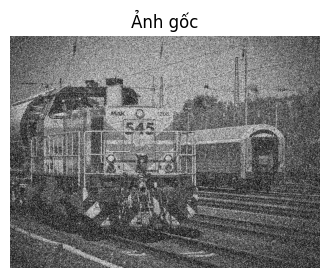

In [2]:
os.makedirs('input', exist_ok=True)
img_path = 'input/Input_4.jpg'

# Tạo ảnh mẫu nếu chưa có
if not os.path.exists(img_path):
    h, w = 256, 256
    base = np.tile(np.linspace(25, 230, w, dtype=np.uint8), (h,1))
    noise = (np.random.randn(h, w) * 12).astype(np.int16)
    noisy = np.clip(base.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    cv2.imwrite(img_path, noisy)
    print('Đã tạo ảnh mẫu:', img_path)

img = load_gray(img_path)
print('Ảnh:', img_path, '| Kích thước:', img.shape)
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title('Ảnh gốc')
plt.axis('off')
plt.show()


# Cấu hình pipeline
- Bật/tắt HE/CLAHE
- Chọn kernel lọc (3/5/7), làm sắc (unsharp/high-boost)
- Chọn thuật toán biên (Sobel/Laplacian/Canny)


In [3]:
cfg = PipelineConfig(
    use_he=False,
    use_clahe=True,
    mean_ksize=None,
    median_ksize=5,
    gauss_ksize=5,
    unsharp_amount=1.0,
    highboost_A=None,
    edge_methods=['sobel','laplacian','canny']
)
cfg


PipelineConfig(use_he=False, use_clahe=True, mean_ksize=None, median_ksize=5, gauss_ksize=5, unsharp_amount=1.0, highboost_A=None, edge_methods=['sobel', 'laplacian', 'canny'])

# Chạy pipeline

In [4]:
res = run_pipeline(img, cfg)
steps = res['steps']
print('Các bước có:', list(steps.keys()))


Các bước có: ['clahe', 'denoise_median', 'denoise_gauss', 'unsharp', 'edges_sobel', 'edges_laplacian', 'edges_canny']


# Hiển thị ảnh sau từng bước

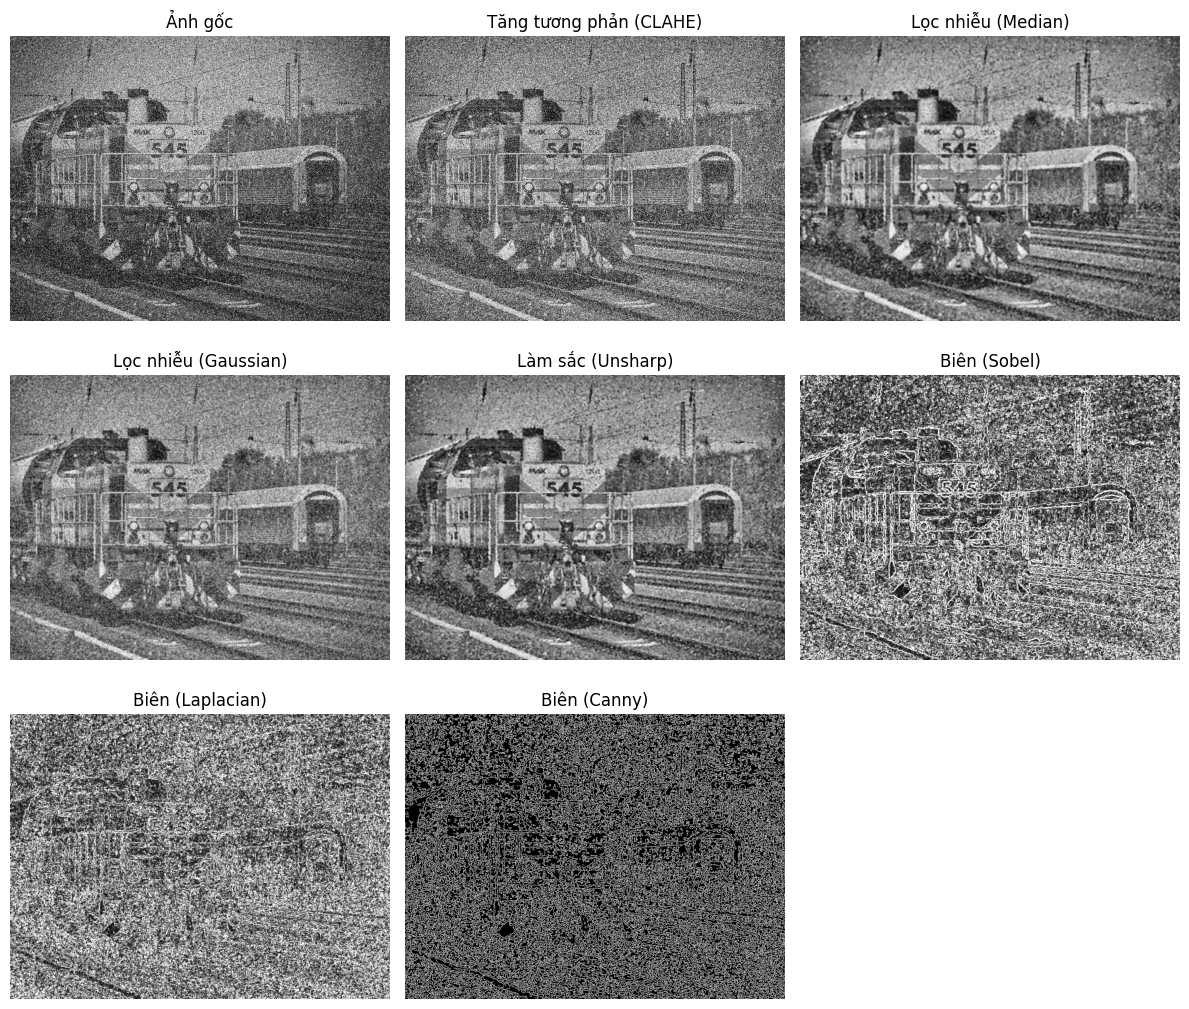

In [5]:
items = [('input', img)] + list(steps.items())
cols = 3
rows = int(np.ceil(len(items)/cols))
plt.figure(figsize=(4*cols, 3.5*rows))
for i,(k,im) in enumerate(items,1):
    plt.subplot(rows, cols, i)
    plt.imshow(im, cmap='gray')
    plt.title(VI_TITLES.get(k,k))
    plt.axis('off')
plt.tight_layout(); plt.show()


# Chỉ số PSNR/SSIM

In [6]:
pairs = []
for k, m in res['metrics'].items():
    pairs.append((VI_TITLES.get(k,k), m['psnr_vs_input'], m['ssim_vs_input']))

# sắp xếp theo SSIM giảm dần
pairs.sort(key=lambda x: x[2], reverse=True)

print(f"{'Bước':28s}  {'PSNR':>8s}  {'SSIM':>8s}")
print('-'*50)
for name, ps, ss in pairs:
    print(f"{name:28s}  {ps:8.2f}  {ss:8.4f}")


Bước                              PSNR      SSIM
--------------------------------------------------
Tăng tương phản (CLAHE)          18.83    0.9451
Lọc nhiễu (Gaussian)             12.17    0.2644
Lọc nhiễu (Median)               11.33    0.0857
Làm sắc (Unsharp)                10.98    0.0769
Biên (Laplacian)                  6.64    0.0072
Biên (Sobel)                      7.28    0.0060
Biên (Canny)                      4.99    0.0009


# Lưu ảnh tổng hợp (grid)

In [7]:
os.makedirs('outputs/notebook_demo', exist_ok=True)
grid_items = [('Ảnh gốc', img)] + [(VI_TITLES.get(k,k), v) for k,v in steps.items()]
out_grid = 'outputs/notebook_demo/Tong_quan_qua_trinh.png'
save_grid(out_grid, grid_items)
print('Đã lưu:', out_grid)


Đã lưu: outputs/notebook_demo/Tong_quan_qua_trinh.png
